In [19]:
#导入需要使用的库
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.callbacks import LearningRateScheduler
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
Train_data=pd.read_csv(r"C:\Users\m1533\Desktop\研一下\python\项目\数据\used_car_train_20200313.csv",sep=" ")
Test_data=pd.read_csv(r"C:\Users\m1533\Desktop\研一下\python\项目\数据\used_car_testB_20200421.csv",sep=" ")

In [2]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


* SaleID	交易ID，唯一编码（del）
* name	汽车交易名称，已脱敏（del）
* regDate	汽车注册日期，例如20160101，2016年01月01日（del）
* model	车型编码，已脱敏（分）
* brand	汽车品牌，已脱敏（分）
* bodyType	车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7（分）
* fuelType	燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6（分）
* gearbox	变速箱：手动：0，自动：1（分）
* power	发动机功率：范围 [ 0, 600 ]（连）
* kilometer	汽车已行驶公里，单位万km（连）
* notRepairedDamage	汽车有尚未修复的损坏：是：0，否：1（分）
* regionCode	地区编码，已脱敏
* seller	销售方：个体：0，非个体：1（del）
* offerType	报价类型：提供：0，请求：1（del）
* creatDate	汽车上线时间，即开始售卖时间
* price	二手车交易价格（预测目标）（连）
* v系列特征	匿名特征，包含v0-14在内15个匿名特征（连）

In [3]:
# 处理长尾分布预测值
Train_data['price'] = np.log1p(Train_data['price'])
# 合并方便后面的操作
df = pd.concat([Train_data, Test_data], ignore_index=True)

# 数据预处理

In [4]:
## 1、第一步处理无用值和基本无变化的值
#SaleID肯定没用，但是我们可以用来统计别的特征的group数量
#name一般没什么好挖掘的，不过同名的好像不少，可以挖掘一下
df['name_count'] = df.groupby(['name'])['SaleID'].transform('count')
del df['name']

In [5]:
#seller有一个特殊值，训练集特有测试集没有，把它删除掉
#df.drop(df[df['seller'] == 1].index, inplace=True)#seller非常不平衡
del df['offerType']# 数据非常不平衡，类别倾斜特别严重
del df['seller']

In [6]:
df['bodyType'].value_counts()#寻找众数用bincount（）

0.0    55185
1.0    47232
2.0    40210
3.0    17982
4.0    12867
5.0    10101
6.0     8694
7.0     1719
Name: bodyType, dtype: int64

In [7]:
## 2、第二步处理缺失值
# 以下特征全部填充众数
df['fuelType'] = df['fuelType'].fillna(0)
df['gearbox'] = df['gearbox'].fillna(0)
df['bodyType'] = df['bodyType'].fillna(0)
df['model'] = df['model'].fillna(0)

In [8]:
## 3、第三步处理异常值
df['power'] = df['power'].map(lambda x: 600 if x>600 else x)#题目要求在600以内
#或者  df['power'][df['power']>600]=600
df['notRepairedDamage'] = df['notRepairedDamage'].astype('str').apply(lambda x: x if x != '-' else None).astype('float32')
#data['notRepairedDamage']=data['notRepairedDamage'].replace('-',0.0).astype(np.float32)

# 特征工程

In [9]:
#时间
from datetime import datetime
def date_process(x):
    year = int(str(x)[:4])#int将字符串再转变为整型
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])

    if month < 1:
        month = 1

    date = datetime(year, month, day)
    return date

In [10]:
df['regDate'] = df['regDate'].apply(date_process)
df['creatDate'] = df['creatDate'].apply(date_process)
#df['regDate_year'] = df['regDate'].dt.year
#df['regDate_month'] = df['regDate'].dt.month
#df['regDate_day'] = df['regDate'].dt.day
#df['creatDate_year'] = df['creatDate'].dt.year
#df['creatDate_month'] = df['creatDate'].dt.month
#df['creatDate_day'] = df['creatDate'].dt.day
df['car_age_day'] = (df['creatDate'] - df['regDate']).dt.days
df['car_age_year'] = round(df['car_age_day'] / 365, 1)

In [11]:
#地区
df['regionCode_count'] = df.groupby(['regionCode'])['SaleID'].transform('count')
df['city'] = df['regionCode'].apply(lambda x : str(x)[:2])#前两个编码代表城市，前提是知道这是德国的邮编;可能泄露price

In [12]:
# 对可分类的连续特征进行分桶，kilometer是已经分桶了
bin = [i*10 for i in range(31)]
df['power_bin'] = pd.cut(df['power'], bin, labels=False)
tong = df[['power_bin', 'power']].head()

In [13]:
bin = [i*10 for i in range(24)]
df['model_bin'] = pd.cut(df['model'], bin, labels=False)
tong = df[['model_bin', 'model']].head()

## 分类特征

In [39]:
Nu_feature = ['power_bin', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
              'v_10', 'v_11', 'v_12', 'v_13','v_14','name_count','car_age_day','regionCode_count']
uncols=['price','regDate','creatDate','SaleID','model','power','regionCode','car_age_year']
Ca_feature = [i for i in df.columns if i not in list(set(Nu_feature).union(set(uncols)))]#取并集
df[Ca_feature]=df[Ca_feature].astype('category')

In [15]:
subsample_index = np.random.randint(low=0, high=len(Train_data), size=37500)
X_data=df.iloc[subsample_index].drop(uncols,axis=1)
Y_data=Train_data['price'].iloc[subsample_index]

In [16]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
num=[df.columns.get_loc(c) for c in Ca_feature]
lgb1=lgb.LGBMRegressor(n_estimators = 1000,objective='mae',categorical_feature=num)
cross_val_score(lgb1,X_data,Y_data,cv=5,scoring='neg_mean_absolute_error').mean()

-0.13067167770679927

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

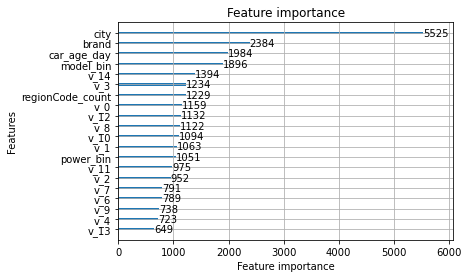

In [17]:
from lightgbm import plot_importance
lgb1.fit(X_data, Y_data)
lgb.plot_importance(lgb1, max_num_features=20)

### 分类特征组合
* 使用分类特征“brand”、“model”、“kilometer”、“bodyType”、“fuelType”与“price”、“days”、“power”进行特征交叉

In [18]:
# 分类特征与price做交叉
Train_data1=df.iloc[:len(Train_data),]
Train_gb = Train_data1.groupby("regionCode")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['regionCode_amount'] = len(kind_data)
    info['regionCode_price_max'] = kind_data.price.max()
    info['regionCode_price_median'] = kind_data.price.median()
    info['regionCode_price_min'] = kind_data.price.min()
    info['regionCode_price_sum'] = kind_data.price.sum()
    info['regionCode_price_std'] = kind_data.price.std()
    info['regionCode_price_mean'] = kind_data.price.mean()
    info['regionCode_price_skew'] = kind_data.price.skew()
    info['regionCode_price_kurt'] = kind_data.price.kurt()
    info['regionCode_mad'] = kind_data.price.mad()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "regionCode"})
df1 = df.merge(brand_fe, how='left', on='regionCode')

Train_gb = Train_data1.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_mean'] = kind_data.price.mean()
    info['brand_price_skew'] = kind_data.price.skew()
    info['brand_price_kurt'] = kind_data.price.kurt()
    info['brand_price_mad'] = kind_data.price.mad()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
df1 = df1.merge(brand_fe, how='left', on='brand')

Train_gb = Train_data1.groupby("model")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['model_amount'] = len(kind_data)
    info['model_price_max'] = kind_data.price.max()
    info['model_price_median'] = kind_data.price.median()
    info['model_price_min'] = kind_data.price.min()
    info['model_price_sum'] = kind_data.price.sum()
    info['model_price_std'] = kind_data.price.std()
    info['model_price_mean'] = kind_data.price.mean()
    info['model_price_skew'] = kind_data.price.skew()
    info['model_price_kurt'] = kind_data.price.kurt()
    info['model_price_mad'] = kind_data.price.mad()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "model"})
df1 = df1.merge(brand_fe, how='left', on='model')

Train_gb = Train_data1.groupby("kilometer")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['kilometer_amount'] = len(kind_data)
    info['kilometer_price_max'] = kind_data.price.max()
    info['kilometer_price_median'] = kind_data.price.median()
    info['kilometer_price_min'] = kind_data.price.min()
    info['kilometer_price_sum'] = kind_data.price.sum()
    info['kilometer_price_std'] = kind_data.price.std()
    info['kilometer_price_mean'] = kind_data.price.mean()
    info['kilometer_price_skew'] = kind_data.price.skew()
    info['kilometer_price_kurt'] = kind_data.price.kurt()
    info['kilometer_price_mad'] = kind_data.price.mad()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "kilometer"})
df1 = df1.merge(brand_fe, how='left', on='kilometer')

Train_gb = Train_data1.groupby("bodyType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['bodyType_amount'] = len(kind_data)
    info['bodyType_price_max'] = kind_data.price.max()
    info['bodyType_price_median'] = kind_data.price.median()
    info['bodyType_price_min'] = kind_data.price.min()
    info['bodyType_price_sum'] = kind_data.price.sum()
    info['bodyType_price_std'] = kind_data.price.std()
    info['bodyType_price_mean'] = kind_data.price.mean()
    info['bodyType_price_skew'] = kind_data.price.skew()
    info['bodyType_price_kurt'] = kind_data.price.kurt()
    info['bodyType_price_mad'] = kind_data.price.mad()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "bodyType"})
df1 = df1.merge(brand_fe, how='left', on='bodyType')


Train_gb = Train_data1.groupby("fuelType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['fuelType_amount'] = len(kind_data)
    info['fuelType_price_max'] = kind_data.price.max()
    info['fuelType_price_median'] = kind_data.price.median()
    info['fuelType_price_min'] = kind_data.price.min()
    info['fuelType_price_sum'] = kind_data.price.sum()
    info['fuelType_price_std'] = kind_data.price.std()
    info['fuelType_price_mean'] = kind_data.price.mean()
    info['fuelType_price_skew'] = kind_data.price.skew()
    info['fuelType_price_kurt'] = kind_data.price.kurt()
    info['fuelType_price_mad'] = kind_data.price.mad()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "fuelType"})
df1 = df1.merge(brand_fe, how='left', on='fuelType')

In [19]:
subsample_index = np.random.randint(low=0, high=len(Train_data), size=37500)
X_data=df1.iloc[subsample_index].drop(uncols,axis=1)
Y_data=Train_data['price'].iloc[subsample_index]

In [20]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
num1=[df1.columns.get_loc(c) for c in Ca_feature]
lgb1=lgb.LGBMRegressor(n_estimators = 1000,objective='mae',categorical_feature=num1)
cross_val_score(lgb1,X_data,Y_data,cv=5,scoring='neg_mean_absolute_error').mean()

-0.12998447940820484

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

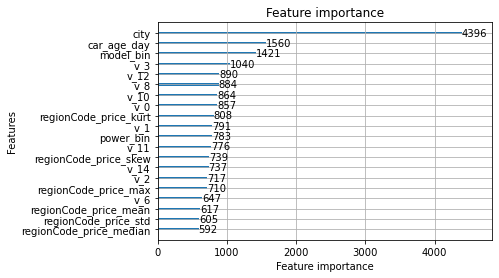

In [21]:
from lightgbm import plot_importance
lgb1.fit(X_data, Y_data)
lgb.plot_importance(lgb1, max_num_features=20)

In [22]:
price_cols=pd.DataFrame({'column': lgb1.feature_name_,'importance': lgb1.feature_importances_ }).sort_values(by='importance',ascending=False)
price_cols=price_cols[price_cols['importance'] != 0]

In [23]:
# 分类特征与days做交叉
Train_gb = Train_data1.groupby("regionCode")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['regionCode_car_age_day_max'] = kind_data.car_age_day.max()
    info['regionCode_car_age_day_median'] = kind_data.car_age_day.median()
    info['regionCode_car_age_day_min'] = kind_data.car_age_day.min()
    info['regionCode_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['regionCode_car_age_day_std'] = kind_data.car_age_day.std()
    info['regionCode_car_age_day_mean'] = kind_data.car_age_day.mean()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "regionCode"})
df2 = df.merge(brand_fe, how='left', on='regionCode')

Train_gb = Train_data1.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['brand_car_age_day_max'] = kind_data.car_age_day.max()
    info['brand_car_age_day_median'] = kind_data.car_age_day.median()
    info['brand_car_age_day_min'] = kind_data.car_age_day.min()
    info['brand_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['brand_car_age_day_std'] = kind_data.car_age_day.std()
    info['brand_car_age_day_mean'] = kind_data.car_age_day.mean()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
df2 = df2.merge(brand_fe, how='left', on='brand')

Train_gb = Train_data1.groupby("model")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['model_car_age_day_max'] = kind_data.car_age_day.max()
    info['model_car_age_day_median'] = kind_data.car_age_day.median()
    info['model_car_age_day_min'] = kind_data.car_age_day.min()
    info['model_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['model_car_age_day_std'] = kind_data.car_age_day.std()
    info['model_car_age_day_mean'] = kind_data.car_age_day.mean()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "model"})
df2 = df2.merge(brand_fe, how='left', on='model')

Train_gb = Train_data1.groupby("kilometer")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['kilometer_car_age_day_max'] = kind_data.car_age_day.max()
    info['kilometer_car_age_day_median'] = kind_data.car_age_day.median()
    info['kilometer_car_age_day_min'] = kind_data.car_age_day.min()
    info['kilometer_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['kilometer_car_age_day_std'] = kind_data.car_age_day.std()
    info['kilometer_car_age_day_mean'] = kind_data.car_age_day.mean()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "kilometer"})
df2 = df2.merge(brand_fe, how='left', on='kilometer')

Train_gb = Train_data1.groupby("bodyType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['bodyType_car_age_day_max'] = kind_data.car_age_day.max()
    info['bodyType_car_age_day_median'] = kind_data.car_age_day.median()
    info['bodyType_car_age_day_min'] = kind_data.car_age_day.min()
    info['bodyType_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['bodyType_car_age_day_std'] = kind_data.car_age_day.std()
    info['bodyType_car_age_day_mean'] = kind_data.car_age_day.mean()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "bodyType"})
df2 = df2.merge(brand_fe, how='left', on='bodyType')


Train_gb = Train_data1.groupby("fuelType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['car_age_day'] > 0]
    info['fuelType_car_age_day_max'] = kind_data.car_age_day.max()
    info['fuelType_car_age_day_median'] = kind_data.car_age_day.median()
    info['fuelType_car_age_day_min'] = kind_data.car_age_day.min()
    info['fuelType_car_age_day_sum'] = kind_data.car_age_day.sum()
    info['fuelType_car_age_day_std'] = kind_data.car_age_day.std()
    info['fuelType_car_age_day_mean'] = kind_data.car_age_day.mean()

    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "fuelType"})
df2 = df2.merge(brand_fe, how='left', on='fuelType')

In [24]:
subsample_index = np.random.randint(low=0, high=len(Train_data), size=37500)
X_data=df2.iloc[subsample_index].drop(uncols,axis=1)
Y_data=Train_data['price'].iloc[subsample_index]

import lightgbm as lgb
from sklearn.model_selection import cross_val_score
num2=[df2.columns.get_loc(c) for c in Ca_feature]
lgb1=lgb.LGBMRegressor(n_estimators = 1000,objective='mae',categorical_feature=num2)
cross_val_score(lgb1,X_data,Y_data,cv=5,scoring='neg_mean_absolute_error').mean()

-0.13267684476182415

In [25]:
lgb1.fit(X_data,Y_data)
day_cols=pd.DataFrame({'column': lgb1.feature_name_,'importance': lgb1.feature_importances_ }).sort_values(by='importance',ascending=False)
day_cols=price_cols[price_cols['importance'] != 0]
#day_cols.iloc[0:50,]

In [26]:
# 分类特征与power做交叉
kk='regionCode'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df.merge(brand_fe, how='left', on=kk)

kk='brand'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df3.merge(brand_fe, how='left', on=kk)

kk='model'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df3.merge(brand_fe, how='left', on=kk)

kk='kilometer'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df3.merge(brand_fe, how='left', on=kk)

kk='bodyType'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df3.merge(brand_fe, how='left', on=kk)

kk='fuelType'
Train_gb = Train_data1.groupby(kk)
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['power'] > 0]
    info[kk+'_power_max'] = kind_data.power.max()
    info[kk+'_power_min'] = kind_data.power.min()
    info[kk+'_power_std'] = kind_data.power.std()
    info[kk+'_power_mean'] = kind_data.power.mean()
    info[kk+'_power_median'] = kind_data.power.median()
    info[kk+'_power_sum'] = kind_data.power.sum()
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": kk})
df3 = df3.merge(brand_fe, how='left', on=kk)

In [27]:
subsample_index = np.random.randint(low=0, high=len(Train_data), size=37500)
X_data=df3.iloc[subsample_index].drop(uncols,axis=1)
Y_data=Train_data['price'].iloc[subsample_index]

import lightgbm as lgb
from sklearn.model_selection import cross_val_score
num3=[df3.columns.get_loc(c) for c in Ca_feature]
lgb1=lgb.LGBMRegressor(n_estimators = 1000,objective='mae',categorical_feature=num3)
cross_val_score(lgb1,X_data,Y_data,cv=5,scoring='neg_mean_absolute_error').mean()

-0.13134107100367406

In [28]:
lgb1.fit(X_data,Y_data)
power_cols=pd.DataFrame({'column': lgb1.feature_name_,'importance': lgb1.feature_importances_}).sort_values(by='importance',ascending=False)
power_cols=price_cols[price_cols['importance'] != 0]
#power_cols.iloc[0:50,]

In [29]:
a=set(price_cols.iloc[0:30,]['column']).union(set(day_cols.iloc[0:30,]['column']))
new_cols=list(a.union(set(power_cols.iloc[0:30,]['column'])).difference(df.columns))
Nu_feature1=Nu_feature+new_cols#新数值变量

## 连续特征交叉

In [30]:
df4=df.copy()
new_cols1=[]
for i in range(15):
    for j in range(15):
        if j >= i:
            df4['new'+str(i)+'*'+str(j)]=df4['v_'+str(i)]*df4['v_'+str(j)]
            new_cols1.append('new'+str(i)+'*'+str(j))
        else:
            continue

In [31]:
new_cols2=[]
for i in range(15):
    for j in range(15):
        if j>=i:
            df4['new'+str(i)+'+'+str(j)]=df4['v_'+str(i)]+df4['v_'+str(j)]
            new_cols2.append('new'+str(i)+'+'+str(j))
        else:
            continue

In [32]:
new_cols=new_cols1+new_cols2

In [33]:
#用相关系数筛选连续特征
import itertools
X_data=df4.iloc[subsample_index].drop(uncols,axis=1)
corr = X_data[new_cols].corr(method='spearman')
feature_group = list(itertools.combinations(corr.columns, 2))#所有长度为r的子序列

# 删除相关性高的变量,调试好直接去主函数进行剔除
def filter_corr(corr, cutoff=0.7):
    cols = []
    for i,j in feature_group:
        if corr.loc[i,j]> cutoff:
            print(i,j,corr.loc[i, j])
            i_avg = corr[i][corr[i] != 1].mean()
            j_avg = corr[j][corr[j] != 1].mean()
            if i_avg >= j_avg:# 超过阈值的两个变量，删掉与其他变量相关性更高的那个
                cols.append(i)
            else:
                cols.append(j)
    return set(cols)

drop_cols = filter_corr(corr, cutoff=0.95)
print(drop_cols)

new0*0 new0+0 1.0
new0*0 new0+5 0.9999801237305751
new0*0 new0+6 0.9996784775058865
new0*0 new0+7 0.9997567219856537
new0*0 new0+8 0.9999398848511166
new0*0 new0+9 0.9998559727145238
new0*1 new1*5 0.9542659314309966
new0*2 new2*5 0.9807454658520649
new0*2 new2+2 0.9996631220840554
new0*2 new2+5 0.9992984767271194
new0*2 new2+6 0.9979674460716622
new0*2 new2+7 0.9992103701647784
new0*2 new2+8 0.9989232547932014
new0*2 new2+9 0.9990730598191444
new0*3 new3*5 0.9781262799295544
new0*3 new3+3 0.9995586789574679
new0*3 new3+5 0.9995921498763978
new0*3 new3+6 0.9992413170968747
new0*3 new3+7 0.9961061157440314
new0*3 new3+8 0.999520218127946
new0*3 new3+9 0.9993948834514059
new0*4 new0*9 0.960148603684706
new0*4 new4*5 0.9889162796409946
new0*4 new4*8 0.9513952968611624
new0*4 new9*9 0.963080872794475
new0*4 new4+4 0.9992241408353326
new0*4 new4+5 0.9981905910531345
new0*4 new4+6 0.9980495918860767
new0*4 new4+7 0.9873741701775435
new0*4 new4+8 0.9988484531661893
new0*4 new4+9 0.999206124525

In [40]:
newnum_cols=list(set(new_cols)-set(drop_cols))
Nu_feature=Nu_feature+newnum_cols+ ['model_power_sum','price','SaleID',
 'model_power_std', 'model_power_median', 'model_power_max', 'brand_price_max', 'brand_price_median',
 'brand_price_sum', 'brand_price_std', 'model_car_age_day_sum', 'model_car_age_day_std', 'model_car_age_day_median', 'model_car_age_day_max', 'model_bin', 'model_amount',
 'model_price_max', 'model_price_median', 'model_price_min', 'model_price_sum', 'model_price_std', 'model_price_mean']

In [41]:
feature=Nu_feature+Ca_feature
data_tree=pd.concat([df,df1,df2,df3,df4],axis=1)[feature]

In [42]:
data_tree=data_tree.T.drop_duplicates(keep='first').T

In [43]:
data_tree[0:len(Train_data)].to_csv('C:\\Users\\m1533\\Desktop\\研一下\\python\\项目\\结果\\'+'tree_train.csv', index=0,sep=' ')
data_tree[len(Train_data):].to_csv('C:\\Users\\m1533\\Desktop\\研一下\\python\\项目\\结果\\'+'tree_test.csv', index=0,sep=' ')

In [16]:
#定义损失函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_absolute_error(np.expm1(label), np.expm1(preds))
    return 'myFeval', score, False